## Opis danych
Wybrany zbiór danych przedstawia ważny problem, z którym codziennie zmagają się firmy zajmujące się wydawaniem kart kredytowych. Posłuży on do predykcji transakcji dokonywanych przy użyciu kradzionych kart kredytowych. Zbudowany w ten sposób model pozwoli na nieobciążanie rachunku klienta, jeśli istnieje transakcja została zainicjowana przy użyciu kradzionej karty kredytowej.

Zbiór danych zawiera transakcje wykonane przy użyciu kart kredytowych w ciągu 2 dni we wrześniu 2013 roku przez Europejczyków. Łączna liczba transakcji w zbiorze to 204807 transakcje. 

## Eksploracyjna analiza danych

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, recall_score, precision_score
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('creditcard.csv')
# df = df.drop('id', axis=1)
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Przykładowy wiersz składa się z 30 atrybutów warunkowych, z czego aż 28 jest wynikiem zastosowania transformacji PCA w ramach preprocessingu. Ze względu na charakter tej metody, nie jesteśmy w stanie uzyskać lepszego kontekstu dla tych atrybutów. Poza tymi atrybutami wyróżniamy również atrybuty 'Time' oraz 'Amount'. Atrybut 'Time' określa czas upływający w sekundach pomiędzy daną transakcją a pierwszą transakcją w zbiorze. Nie ma on większego znaczenia w kontekście badanego problemu (pełni rolę pewnego atrybutu porządkowego). 'Amount' z kolei określa kwotę transakcji, którą będzie obciążony posiadacz karty. Atrybutem decyzyjnym jest flaga, która określa, czy dana transakcja została wykonana przy użyciu karty kupującego (0) czy przy użyciu kradzionej karty (1).

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Analiza brakujących wartości - brak takowych w badanym zbiorze.

In [4]:
total = df.isna().sum().sort_values(ascending=False)
total.head()

Time      0
V16       0
Amount    0
V28       0
V27       0
dtype: int64

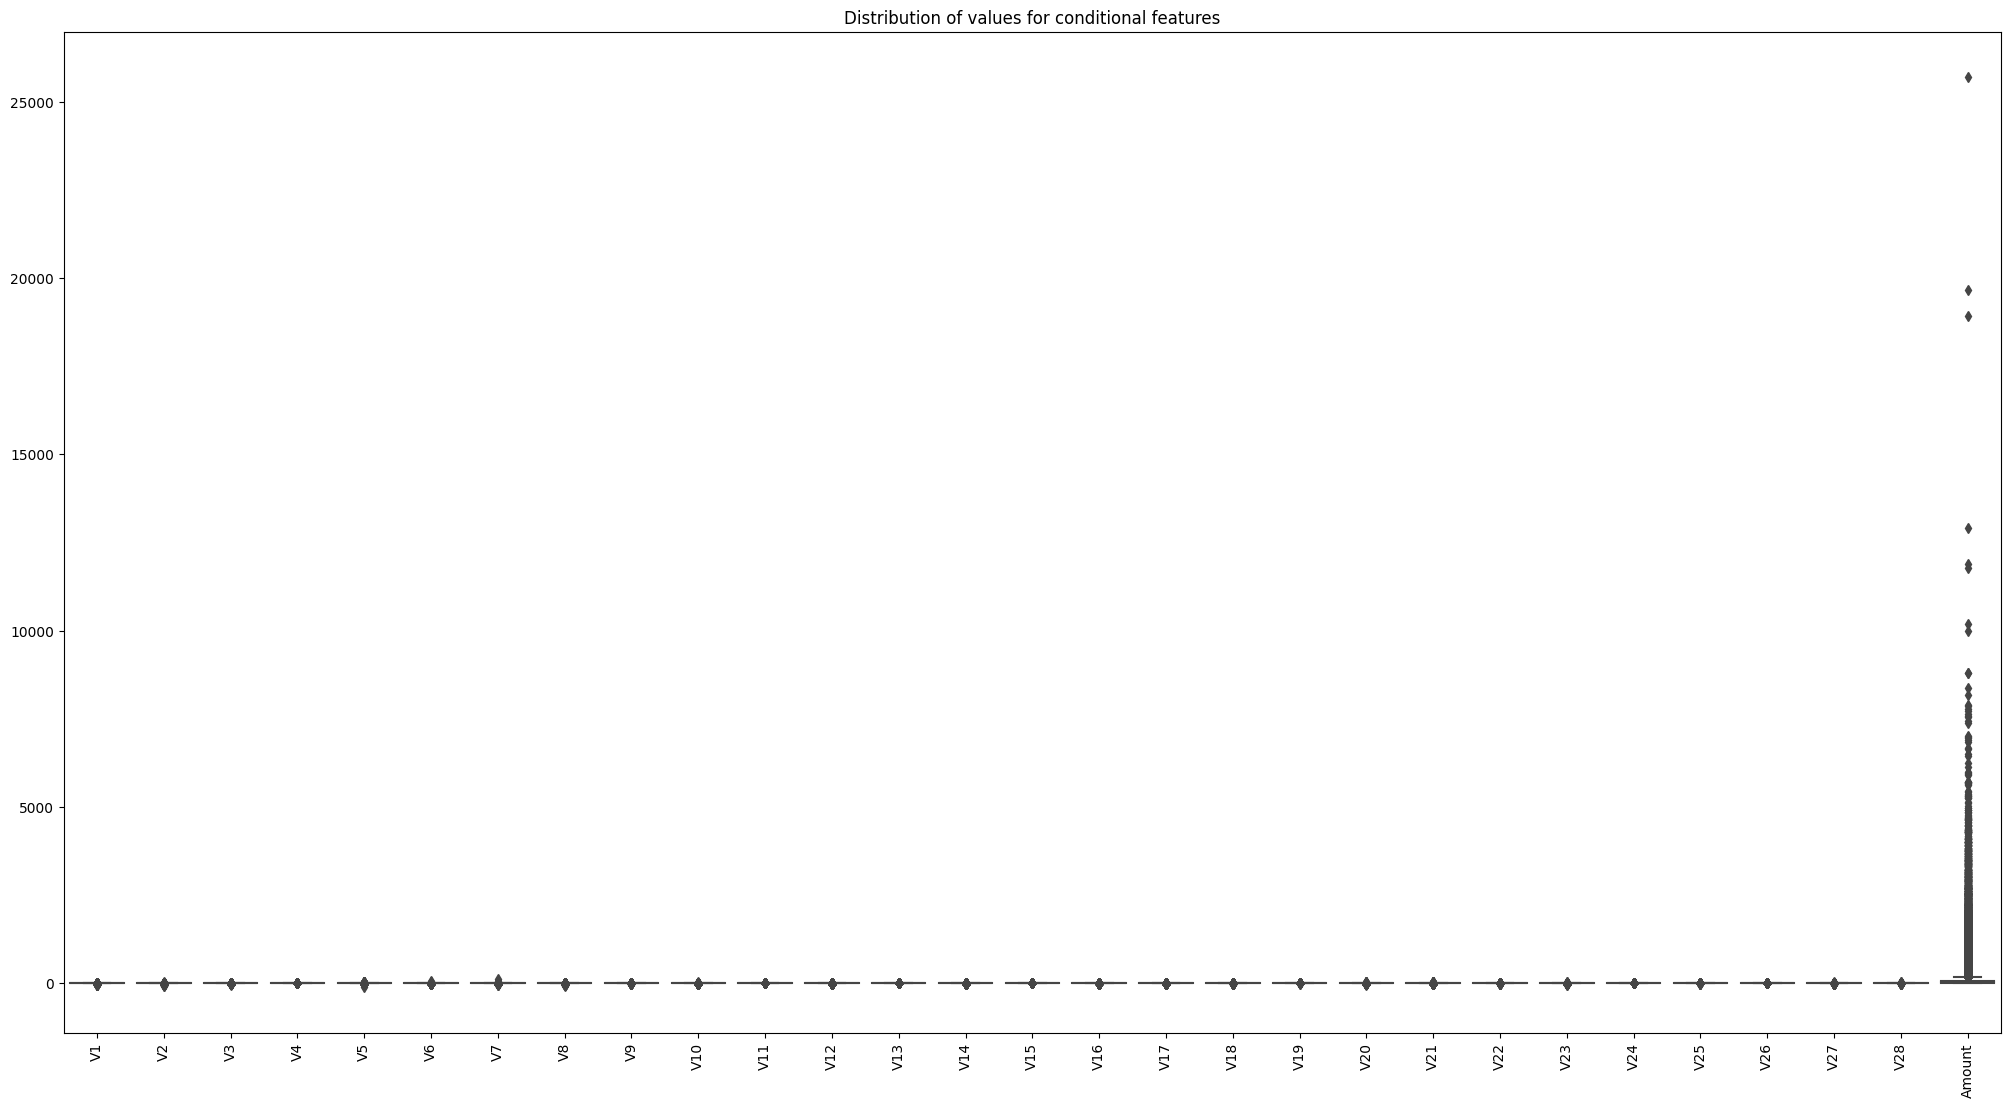

In [7]:
plt.subplots(figsize=(25, 13), facecolor=(1, 1, 1))
sns.boxplot(data=df.drop(columns=['Class', 'Time']))
plt.xticks(rotation=90)
plt.title('Distribution of values for conditional features')
plt.show()

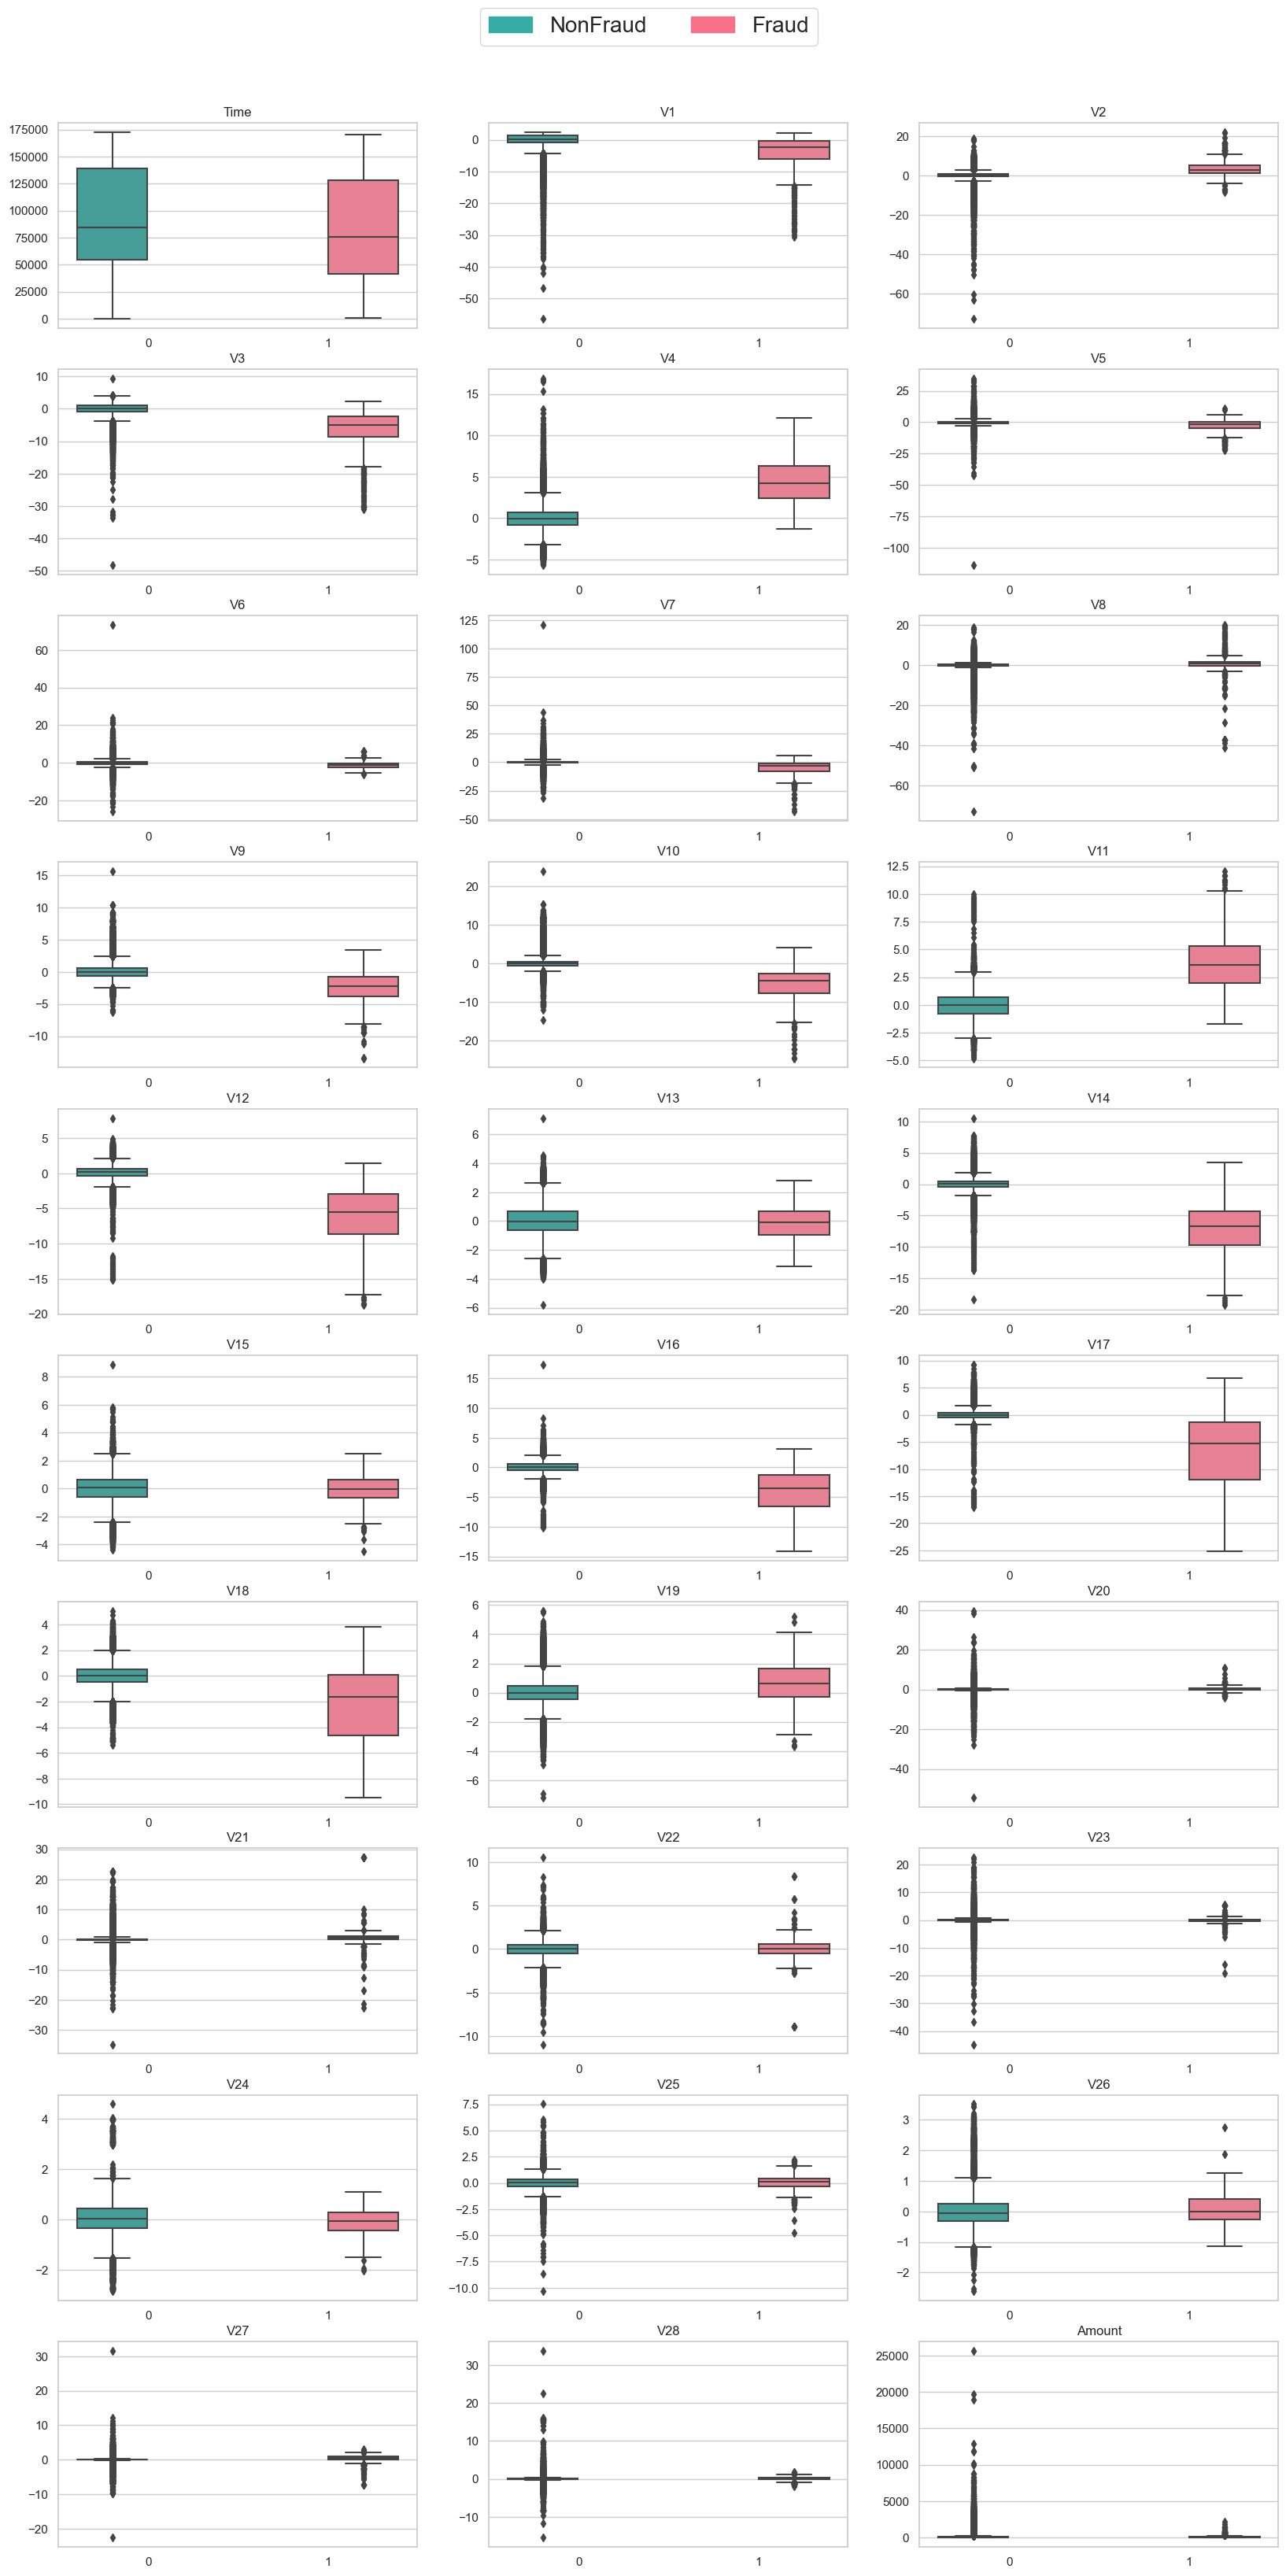

In [11]:
colors = ['#36ada4', '#f77189'] 
sns.set_theme(
    style='whitegrid',
    palette=sns.color_palette(colors)
)

fig, ax = plt.subplots(10, 3, figsize=(20, 40))
ax = ax.flatten()
total_col = df.columns.drop(['Class'])
for idx, col in enumerate(total_col):
    sns.boxplot(data=df, y=col, x="Class", hue="Class", ax=ax[idx])
    ax[idx].legend().remove()
    ax[idx].set(title=col)
    ax[idx].set(xlabel=None)
    ax[idx].set(ylabel=None)

labels = ['NonFraud', 'Fraud']

pop_a = mpatches.Patch(color=colors[0], label=labels[0])
pop_b = mpatches.Patch(color=colors[1], label=labels[1])
fig.legend(handles=[pop_a, pop_b], loc='upper center', bbox_to_anchor=(0.5, .92), fontsize=20, ncol=2)
plt.show()

Ze względu na różne rozkłady poszczególnych atrybutów, każdy z nich zostanie poddanych standaryzacji w procesie budowania modelu. Można zauważyć liczne obserwacje odstające dla atrybutu 'Amount', zwłaszcza dla grupy zaklasyfikowanej jako transakcje legalne. Dużo niższe kwoty są przyjmowane dla transakcji kradzionymi kartami, najprawdopodobniej ze względu na limity płatności kartą bez znajomości kodu PIN. 

Jak można zauważyć, dane są mocno niezbalansowane. Tylko ok. 0,17% przypadków zostało sklasyfikowanych jako transakcje skradzioną kartą w podanym zbiorze.

In [19]:
display(pd.DataFrame(df['Class'].value_counts()).reset_index())
display(pd.DataFrame(df['Class'].value_counts(normalize=True) * 100).reset_index())

,Class,count
0,0,284315
1,1,492


,Class,proportion
0,0,99.827251
1,1,0.172749


Poniższa heatmapa sugeruje, że w wejściowych danych nie występuje korelacja między poszczególnymi atrybutami.

<Axes: >

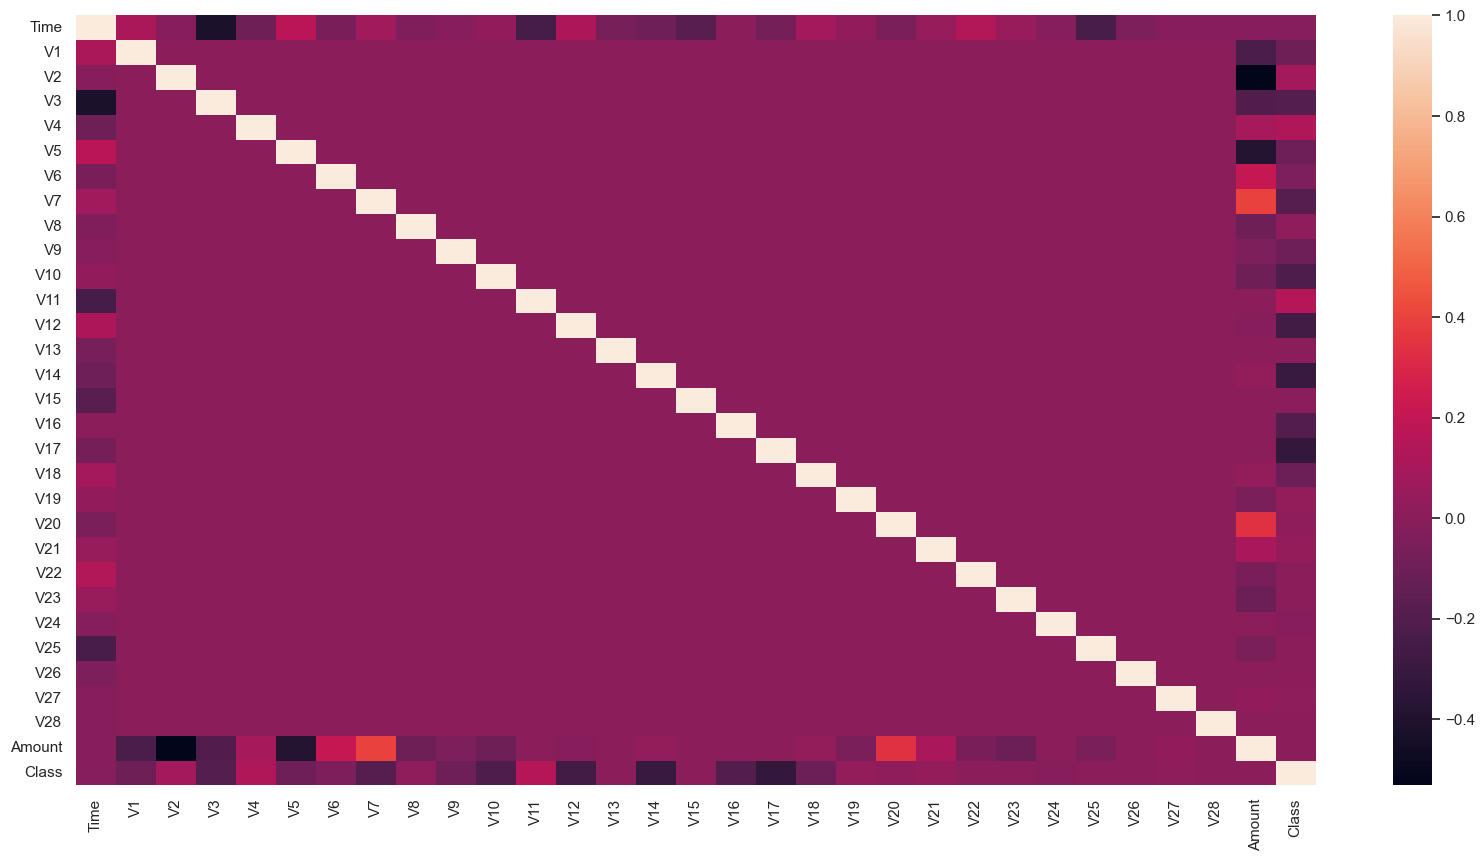

In [21]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr())

## Budowa modelu
Do budowy końcowego modelu posłużę się trzema dostępnymi klasyfikatorami:

1. LogisticRegression
2. RandomForestClassifier
3. GaussianNB

Wykonanie predykcji posługując się powyższymi algorytmami będzie prostym przepływem, poprzedzonym standaryzacją danych. Z uwagi wysoki stopień niezbalansowania danych, konieczne będzie zastosowanie technik poprawiających zdolności predykcyjne poszczególnych modeli. Dla metod posiadających parametr *class_weight*, ustawienie jego wartości na 'balanced' poprawi jakość predykcji. Z kolei dla metody GaussianNB w tym celu wykorzystam oversampling przy wykorzystaniu metody SMOTE. Metrykami służacymi do oceny trafności poszczególnych modeli będą tradycyjna trafność, G-mean oraz ROC AUC. Wyznaczając końcowy model skorzystam z podejścia ensemble learning, służącego do połączenia testowanych modeli oraz stworzenia jednego optymalnego modelu predykcyjnego.

In [112]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["Class", "Time"]), df["Class"], test_size=0.25, random_state=42)

* Regresja logistyczna

In [113]:
results = []
lr_clf = LogisticRegression(penalty='l2', class_weight='balanced', random_state=42, max_iter=200)
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)
results.append(dict(name='Logistic Regression', acc=accuracy_score(y_test, y_pred), gmean=geometric_mean_score(y_test, y_pred), 
                    rocauc=roc_auc_score(y_test, y_pred), precision=precision_score(y_test, y_pred), recall=recall_score(y_test, y_pred)))

c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Las losowy

In [114]:
rf_clf = RandomForestClassifier(n_estimators=10, class_weight='balanced', random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
results.append(dict(name='Random Forest', acc=accuracy_score(y_test, y_pred), gmean=geometric_mean_score(y_test, y_pred), 
                    rocauc=roc_auc_score(y_test, y_pred), precision=precision_score(y_test, y_pred), recall=recall_score(y_test, y_pred)))

* Naiwny Bayes

In [115]:
oversample = SMOTE(sampling_strategy="minority", random_state=4)
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)
y_train_smote.value_counts()

Class
0    213226
1    213226
Name: count, dtype: int64

In [116]:
nb_clf = GaussianNB()
nb_clf.fit(X_train_smote, y_train_smote)
y_pred = nb_clf.predict(X_test)
results.append(dict(name='Naive Bayes', acc=accuracy_score(y_test, y_pred), gmean=geometric_mean_score(y_test, y_pred), 
                    rocauc=roc_auc_score(y_test, y_pred), precision=precision_score(y_test, y_pred), recall=recall_score(y_test, y_pred)))

In [117]:
results = pd.DataFrame(results)
results

,name,acc,gmean,rocauc,precision,recall
0,Logistic Regression,0.973891,0.946786,0.947165,0.053224,0.920354
1,Random Forest,0.999508,0.862149,0.871639,0.933333,0.743363
2,Naive Bayes,0.975759,0.919991,0.921594,0.054174,0.867257


* Ensemble learning

In [118]:
lr_pred = lr_clf.predict_proba(X_test)[:, 1]
rf_pred = rf_clf.predict_proba(X_test)[:, 1]
nb_clf = nb_clf.predict_proba(X_test)[:, 1]

coefficients = [1, 0.1, 0.1]
ensemble_preds = np.sum([coefficients[0] * lr_pred + coefficients[1] * rf_pred + coefficients[2] * nb_clf], axis=0) / sum(coefficients)

* Ewaluacja modelu

In [119]:
results = [dict(name='Ensemble method', acc=accuracy_score(y_test, (ensemble_preds > 0.5)), gmean=geometric_mean_score(y_test, (ensemble_preds > 0.5)),
                rocauc=roc_auc_score(y_test, y_pred), precision=precision_score(y_test, y_pred), recall=recall_score(y_test, y_pred))]

In [120]:
pd.DataFrame(results)

,name,acc,gmean,rocauc,precision,recall
0,Ensemble method,0.981868,0.950661,0.921594,0.054174,0.867257


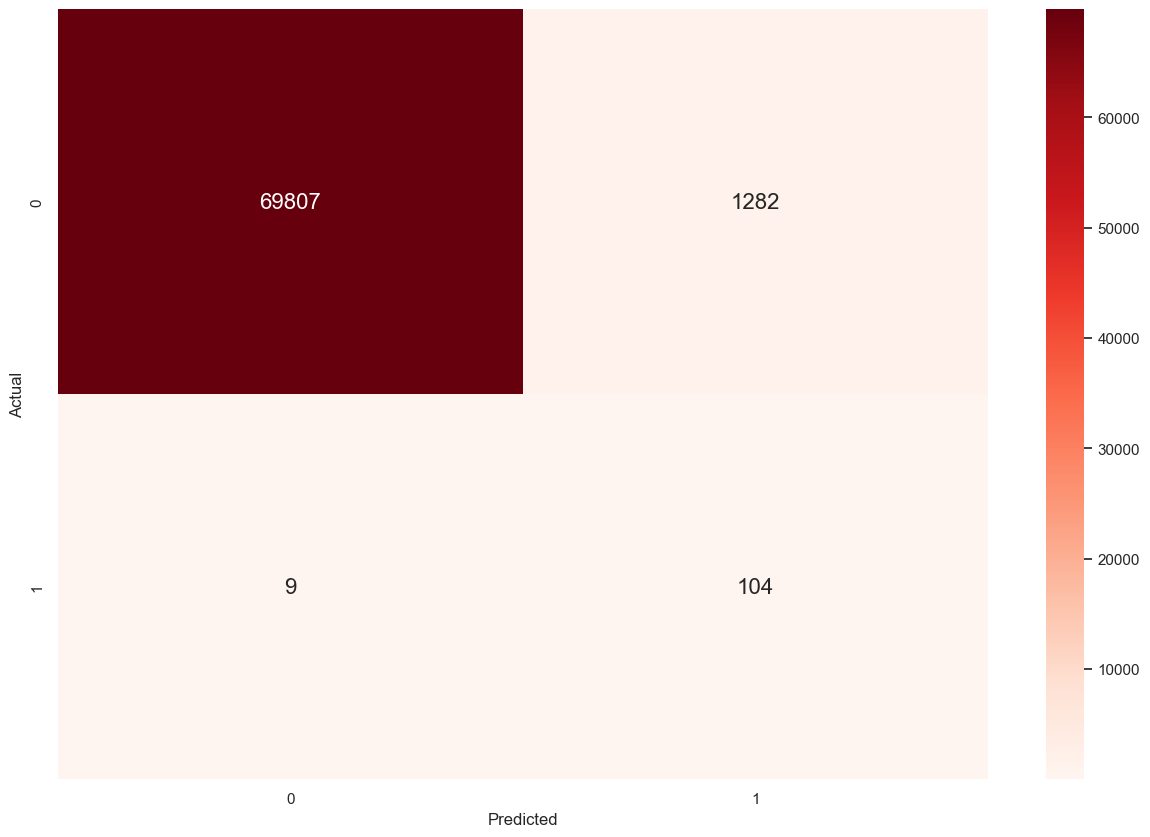

In [121]:
cm = confusion_matrix(y_test, (ensemble_preds > 0.5))
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='g', annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

W końcowym modelu uznałem, że regresja logistyczna najlepiej poradziła sobie z problemem niezrównoważenia atrybutu decyzyjnego w podanym zbiorze, dlatego jej współczynnik jest 10-krotnie wyższy. Ze względu na fakt, że błąd polegający na wykryciu niestniejącej kradzieży i anulowanie transakcji jest mniej kosztowny niż potencjalny brak wykrycia kradzieży karty, uzyskane wyniki predykcji wydają się satysfakcjonujące. Problem niezbalansowanych danych został więc rozwiązany przy pomocy odpowiedniego zrównoważenia wag dla danej klasy bądź przy zastosowaniu oversamplingu i metody SMOTE.